# Tugas 4_V2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Install dan import modul yang diperlukan
!pip install Sastrawi
import nltk

# Pastikan untuk mengunduh 'punkt' yang dibutuhkan NLTK
nltk.download('punkt')

# Import library lain yang dibutuhkan
import pandas as pd
import numpy as np
import re
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx
import matplotlib.pyplot as plt

# ...lanjutkan dengan kode lainnya


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
# Baca file CSV
df = pd.read_csv("/content/drive/MyDrive/PPW-A/report/Tugas-PPW-A/data_berita_detik.csv")
df.head()

,judul,tanggal,isi,kategori
0,Para Tua-tua Keladi di NBA,"Selasa, 08 Okt 2024 17:50 WIB","Jakarta - Jelang musim NBA 2024-2025, masih ad...",Olahraga
1,Akhir Dramatis Pertahankan Gelar di Final AXIS...,"Selasa, 08 Okt 2024 15:57 WIB",Malang - Turnamen AXIS Nation Cup 2024 di Sudi...,Olahraga
2,Artur Beterbiev Bagai Khabib Nurmagomedov di D...,"Selasa, 08 Okt 2024 15:15 WIB",Jakarta - Khabib Nurmagomedov merupakan legend...,Olahraga
3,Isekai Run: Event Lari Terbesar di Jakarta Coc...,"Selasa, 08 Okt 2024 14:21 WIB",Jakarta - Siap merasakan pengalaman lari palin...,Olahraga
4,Murid Marc Marquez di Ambang Pecahkan Rekor Va...,"Selasa, 08 Okt 2024 11:15 WIB",Jakarta - Sebuah rekor berusia 27 tahun dari V...,Olahraga


In [ ]:
# mengambil satu sample berita
sample_berita = df['isi'].iloc[4]
print(sample_berita)

Jakarta - Sebuah rekor berusia 27 tahun dari Valentino Rossi berpeluang pecah pada tahun ini. David Alonso adalah nama rider yang punya kans melakukannya. Hal itu terjadi seiring kemenangan David Alonso dalam balapan Moto3 di Motegi pada akhir pekan lalu. Rider Kolombia kelahiran Madrid 18 tahun lalu itu pun memastikan gelar juara dunia Moto3 2024. Keberhasilan naik podium teratas di Motegi adalah kemenangan nomor 10 bagi David Alonso di Moto3 musim ini. Pencapaian ini bikin dirinya menyamai Fausto Gresini, Marc Marquez, dan Joan Mir yang juga 10 kali menang di Moto3/125cc. Dengan hasil tersebut David Alonso kian dekat dengan rekor jumlah kemenangan di kelas tersebut. Ada Valentino Rossi yang pegang rekor itu dengan 11 kemenangan di kelas 125cc pada tahun 1997. Namun, patut pula dicatat bahwa Valentino Rossi meraih 11 kemenangan ketika kelas 125cc cuma menjalani 15 seri balapan pada 27 tahun silam. Ada beda jumlah seri balapan dengan yang dijalani David Alonso tahun ini. David Alonso m

In [ ]:
# Membuat list untuk menyimpan hasil
result_list = []

# Pisahkan kalimat berdasarkan titik
sentences = sample_berita.split('.')  # Pisahkan kalimat berdasarkan titik
sentences = [s.strip() for s in sentences if s.strip()]  # Hilangkan spasi berlebih dan kosong

# Looping untuk menambahkan setiap kalimat ke result_list
for i, sentence in enumerate(sentences, 1):
    result_list.append({'kalimat ke n': f"Kalimat ke {i}", 'kalimat': sentence})

# Membuat DataFrame dari hasil pemisahan
result_df = pd.DataFrame(result_list)

# Tampilkan DataFrame
result_df

,kalimat ke n,kalimat
0,Kalimat ke 1,Jakarta - Sebuah rekor berusia 27 tahun dari V...
1,Kalimat ke 2,David Alonso adalah nama rider yang punya kans...
2,Kalimat ke 3,Hal itu terjadi seiring kemenangan David Alons...
3,Kalimat ke 4,Rider Kolombia kelahiran Madrid 18 tahun lalu ...
4,Kalimat ke 5,Keberhasilan naik podium teratas di Motegi ada...
5,Kalimat ke 6,Pencapaian ini bikin dirinya menyamai Fausto G...
6,Kalimat ke 7,Dengan hasil tersebut David Alonso kian dekat ...
7,Kalimat ke 8,Ada Valentino Rossi yang pegang rekor itu deng...
8,Kalimat ke 9,"Namun, patut pula dicatat bahwa Valentino Ross..."
9,Kalimat ke 10,Ada beda jumlah seri balapan dengan yang dijal...


In [ ]:
# Download stopwords untuk bahasa Indonesia
nltk.download('stopwords')
stop_words = stopwords.words('indonesian')

# Fungsi preprocessing yang disesuaikan
def remove_url(data_berita):
    url = re.compile(r'https?://\S+|www\.S+')
    return url.sub(r'', data_berita)

def remove_html(data_berita):
    html = re.compile(r'<.#?>')
    return html.sub(r'', data_berita)

def remove_emoji(data_berita):
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticon
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', data_berita)

def remove_numbers(data_berita):
    data_berita = re.sub(r'\d+', '', data_berita)
    return data_berita

def remove_symbols(data_berita):
    data_berita = re.sub(r'[^a-zA-Z0-9\s]', '', data_berita)
    return data_berita

def case_folding(text):
    if isinstance(text, str):
        return text.lower()
    return text

def tokenize(text):
    return text.split()

def remove_stopwords(text):
    return [word for word in text if word not in stop_words]

# Inisialisasi stemmer
factory = StemmerFactory()
stemmer = factory.create_stemmer()

def stemming(text):
    return [stemmer.stem(word) for word in text]

# Looping setiap kalimat di dataframe 'result_df'
result_df['clean'] = result_df['kalimat'].apply(remove_url)
result_df['clean'] = result_df['clean'].apply(remove_html)
result_df['clean'] = result_df['clean'].apply(remove_emoji)
result_df['clean'] = result_df['clean'].apply(remove_symbols)
result_df['clean'] = result_df['clean'].apply(remove_numbers)
result_df['clean'] = result_df['clean'].apply(case_folding)
result_df['tokenize'] = result_df['clean'].apply(tokenize)
result_df['stopword removal'] = result_df['tokenize'].apply(remove_stopwords)
result_df['stemming'] = result_df['stopword removal'].apply(stemming)

# Gabungkan kata setelah stemming
result_df['final'] = result_df['stemming'].apply(lambda x: ' '.join(x))

# Tampilkan hasil dataframe
result_df[['kalimat ke n', 'final']]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,kalimat ke n,final
0,Kalimat ke 1,jakarta rekor usia valentino rossi peluang pecah
1,Kalimat ke 2,david alonso nama rider kans laku
2,Kalimat ke 3,iring menang david alonso balap moto motegi pekan
3,Kalimat ke 4,rider kolombia lahir madrid gelar juara dunia ...
4,Kalimat ke 5,hasil podium atas motegi menang nomor david al...
5,Kalimat ke 6,capai bikin sama fausto gresini marc marquez j...
6,Kalimat ke 7,hasil david alonso kian rekor menang kelas
7,Kalimat ke 8,valentino rossi pegang rekor menang kelas cc
8,Kalimat ke 9,patut catat valentino rossi raih menang kelas ...
9,Kalimat ke 10,beda seri balap jalan david alonso


In [ ]:
# Gabungkan semua kalimat hasil stemming menjadi dokumen untuk tiap kalimat
documents = result_df['final'].tolist()

# Inisialisasi TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Terapkan TF-IDF ke dokumen (kalimat yang sudah dipreproses)
tfidf_matrix = tfidf_vectorizer.fit_transform(documents)

# Mendapatkan nama-nama fitur (kata-kata)
feature_names = tfidf_vectorizer.get_feature_names_out()

# Mengubah hasil TF-IDF menjadi dataframe
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)

# Tambahkan kolom 'no' dan 'kalimat ke n' untuk identifikasi
tfidf_df.insert(0, 'kalimat ke n', result_df['kalimat ke n'])

# Tampilkan dataframe dengan skor TF-IDF
tfidf_df

,kalimat ke n,ajang,alam,alonso,aspar,atas,balap,beda,bicara,bidik,...,seri,silam,tanda,team,tengah,terburuburu,tiga,total,usia,valentino
0,Kalimat ke 1,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0000,0.00000,0.000000,0.000000,0.00000,0.000000,0.433821,0.311560
1,Kalimat ke 2,0.000000,0.000000,0.234907,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
2,Kalimat ke 3,0.000000,0.000000,0.226093,0.00000,0.000000,0.373981,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
3,Kalimat ke 4,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
4,Kalimat ke 5,0.000000,0.000000,0.192765,0.00000,0.405249,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
5,Kalimat ke 6,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
6,Kalimat ke 7,0.000000,0.000000,0.250422,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
7,Kalimat ke 8,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.352188
8,Kalimat ke 9,0.000000,0.000000,0.000000,0.00000,0.000000,0.269185,0.000000,0.000000,0.000000,...,0.245705,0.342123,0.0000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.245705
9,Kalimat ke 10,0.000000,0.000000,0.258645,0.00000,0.000000,0.427825,0.543747,0.000000,0.000000,...,0.390506,0.000000,0.0000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000


In [ ]:
# Menghitung cosine similarity antar kalimat berdasarkan TF-IDF
cosine_sim = cosine_similarity(tfidf_matrix)

# Membuat dataframe untuk menyimpan hasil cosine similarity
cosine_sim_df = pd.DataFrame(cosine_sim, index=result_df['kalimat ke n'], columns=result_df['kalimat ke n'])

# Tampilkan matriks cosine similarity
cosine_sim_df

kalimat ke n,Kalimat ke 1,Kalimat ke 2,Kalimat ke 3,Kalimat ke 4,Kalimat ke 5,Kalimat ke 6,Kalimat ke 7,Kalimat ke 8,Kalimat ke 9,Kalimat ke 10,Kalimat ke 11,Kalimat ke 12,Kalimat ke 13,Kalimat ke 14,Kalimat ke 15,Kalimat ke 16,Kalimat ke 17,Kalimat ke 18
kalimat ke n,,,,,,,,,,,,,,,,,,
Kalimat ke 1,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.117799,0.329183,0.153104,0.000000,0.000000,0.390887,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
Kalimat ke 2,0.000000,1.000000,0.112970,0.121848,0.096317,0.000000,0.125126,0.000000,0.000000,0.129234,0.123495,0.092567,0.113631,0.111540,0.053506,0.000000,0.060182,0.0
Kalimat ke 3,0.000000,0.112970,1.000000,0.071578,0.348107,0.048348,0.202767,0.076695,0.154177,0.284383,0.293441,0.089094,0.195230,0.065523,0.051498,0.000000,0.132431,0.0
Kalimat ke 4,0.000000,0.121848,0.071578,1.000000,0.061027,0.000000,0.000000,0.000000,0.000000,0.000000,0.078247,0.000000,0.071997,0.144960,0.000000,0.000000,0.231954,0.0
Kalimat ke 5,0.000000,0.096317,0.348107,0.061027,1.000000,0.041221,0.336332,0.065390,0.045619,0.106050,0.250186,0.157368,0.266383,0.132122,0.043907,0.000000,0.112910,0.0
Kalimat ke 6,0.000000,0.000000,0.048348,0.000000,0.041221,1.000000,0.053551,0.049882,0.034800,0.000000,0.052853,0.000000,0.000000,0.000000,0.167993,0.059087,0.088833,0.0
Kalimat ke 7,0.117799,0.125126,0.202767,0.000000,0.336332,0.053551,1.000000,0.351267,0.152164,0.137770,0.221660,0.204438,0.121136,0.000000,0.057040,0.000000,0.201669,0.0
Kalimat ke 8,0.329183,0.000000,0.076695,0.000000,0.065390,0.049882,0.351267,1.000000,0.443344,0.000000,0.083841,0.295532,0.000000,0.000000,0.000000,0.000000,0.128091,0.0
Kalimat ke 9,0.153104,0.000000,0.154177,0.000000,0.045619,0.034800,0.152164,0.443344,1.000000,0.353636,0.150180,0.206178,0.000000,0.000000,0.000000,0.000000,0.089363,0.0


In [ ]:
# Tetapkan ambang batas (threshold) 0.7
threshold = 0.5

# Buat matriks adjacency: jika cosine similarity >= 0.6, maka 1; jika tidak, maka 0
adjacency_matrix = np.where(cosine_sim >= threshold, 1, 0)

# Buat dataframe untuk menampilkan matriks adjacency
adjacency_df = pd.DataFrame(adjacency_matrix, index=result_df['kalimat ke n'], columns=result_df['kalimat ke n'])

# Tampilkan matriks adjacency
adjacency_df

kalimat ke n,Kalimat ke 1,Kalimat ke 2,Kalimat ke 3,Kalimat ke 4,Kalimat ke 5,Kalimat ke 6,Kalimat ke 7,Kalimat ke 8,Kalimat ke 9,Kalimat ke 10,Kalimat ke 11,Kalimat ke 12,Kalimat ke 13,Kalimat ke 14,Kalimat ke 15,Kalimat ke 16,Kalimat ke 17,Kalimat ke 18
kalimat ke n,,,,,,,,,,,,,,,,,,
Kalimat ke 1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Kalimat ke 2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Kalimat ke 3,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Kalimat ke 4,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Kalimat ke 5,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
Kalimat ke 6,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
Kalimat ke 7,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
Kalimat ke 8,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
Kalimat ke 9,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


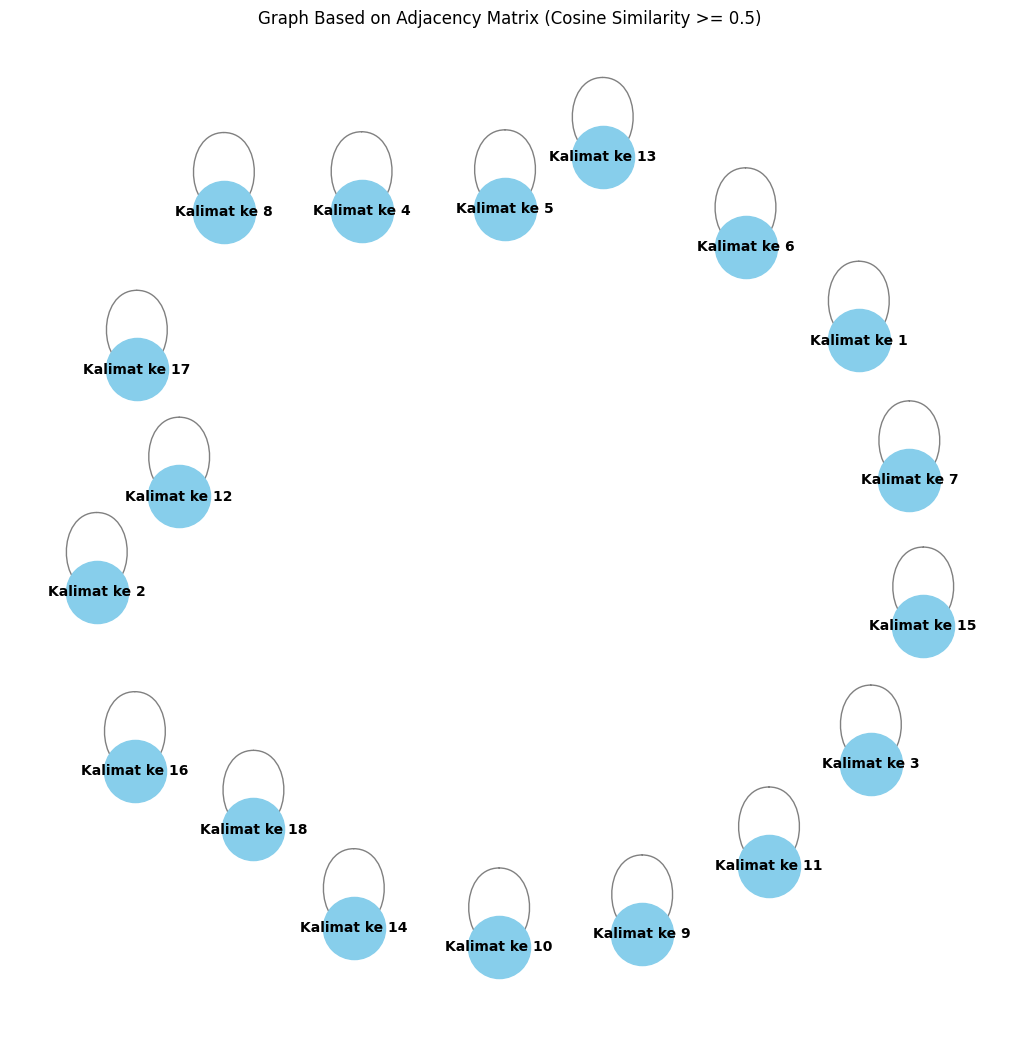

In [ ]:
# Buat graf dari matriks adjacency
G = nx.from_numpy_array(adjacency_matrix)

# Atur label node agar sesuai dengan 'kalimat ke n'
mapping = {i: f"Kalimat ke {i+1}" for i in range(len(result_df))}
G = nx.relabel_nodes(G, mapping)

# Menggambar graf
plt.figure(figsize=(10, 10))
pos = nx.spring_layout(G)  # Atur layout graf
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=2000, font_size=10, font_color='black', edge_color='gray', linewidths=1, font_weight='bold')

# Tampilkan graf
plt.title("Graph Based on Adjacency Matrix (Cosine Similarity >= 0.5)")
plt.show()

In [ ]:
# Menghitung betweenness centrality
betweenness_centrality = nx.betweenness_centrality(G)

# Menghitung degree centrality
degree_centrality = nx.degree_centrality(G)

# Menghitung closeness centrality
closeness_centrality = nx.closeness_centrality(G)

# Buat dataframe untuk menampilkan hasil centrality
centrality_df = pd.DataFrame({
    'Kalimat': list(betweenness_centrality.keys()),
    'Betweenness Centrality': list(betweenness_centrality.values()),
    'Degree Centrality': list(degree_centrality.values()),
    'Closeness Centrality': list(closeness_centrality.values())
})

# Tampilkan dataframe centrality
centrality_df

,Kalimat,Betweenness Centrality,Degree Centrality,Closeness Centrality
0,Kalimat ke 1,0.0,0.117647,0.0
1,Kalimat ke 2,0.0,0.117647,0.0
2,Kalimat ke 3,0.0,0.117647,0.0
3,Kalimat ke 4,0.0,0.117647,0.0
4,Kalimat ke 5,0.0,0.117647,0.0
5,Kalimat ke 6,0.0,0.117647,0.0
6,Kalimat ke 7,0.0,0.117647,0.0
7,Kalimat ke 8,0.0,0.117647,0.0
8,Kalimat ke 9,0.0,0.117647,0.0
9,Kalimat ke 10,0.0,0.117647,0.0


# Pengujian

Masukkan isi berita: Moto

Pilih jenis centrality yang ingin dihitung:
1. Betweenness Centrality
2. Degree Centrality
3. Closeness Centrality
Masukkan pilihan (1/2/3): 1

Hasil Pemisahan Kalimat:
   kalimat ke n kalimat final
0  Kalimat ke 1    Moto  moto

Cosine Similarity Matrix:
[[1.]]

Adjacency Matrix:
[[1]]

Graph:


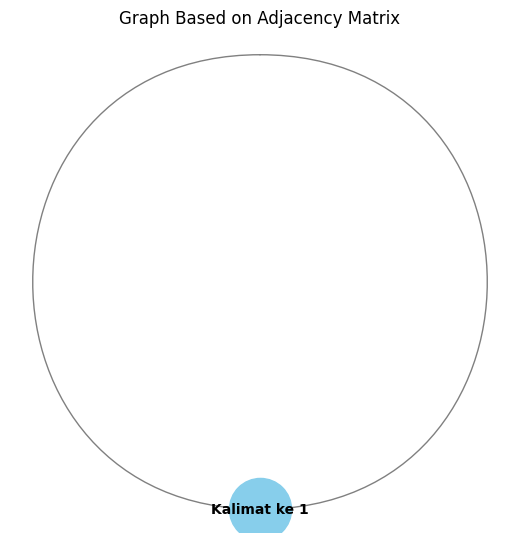


Nilai Centrality:
        Kalimat  Betweenness Centrality  Degree Centrality  \
0  Kalimat ke 1                     0.0                  1   

   Closeness Centrality  
0                   0.0  

Ringkasan (3 Kalimat Teratas Berdasarkan Betweenness Centrality):
        Kalimat  Betweenness Centrality
0  Kalimat ke 1                     0.0


In [ ]:
# Fungsi untuk memisahkan dan memproses berita
def process_news_input(user_input):
    # Memisahkan kalimat
    result_list = []
    sentences = user_input.split('.')  # Pisahkan kalimat berdasarkan titik
    sentences = [s.strip() for s in sentences if s.strip()]  # Hilangkan spasi berlebih dan kosong
    for i, sentence in enumerate(sentences, 1):
        result_list.append({'kalimat ke n': f"Kalimat ke {i}", 'kalimat': sentence})

    result_df = pd.DataFrame(result_list)

    # Fungsi preprocessing yang disesuaikan
    def remove_url(data_berita):
        url = re.compile(r'https?://\S+|www\.S+')
        return url.sub(r'', data_berita)

    def remove_html(data_berita):
        html = re.compile(r'<.#?>')
        return html.sub(r'', data_berita)

    def remove_emoji(data_berita):
        emoji_pattern = re.compile("["u"\U0001F600-\U0001F64F"
                                   u"\U0001F300-\U0001F5FF"
                                   u"\U0001F680-\U0001F6FF"
                                   u"\U0001F1E0-\U0001F1FF""]+", flags=re.UNICODE)
        return emoji_pattern.sub(r'', data_berita)

    def remove_numbers(data_berita):
        data_berita = re.sub(r'\d+', '', data_berita)
        return data_berita

    def remove_symbols(data_berita):
        data_berita = re.sub(r'[^a-zA-Z0-9\s]', '', data_berita)
        return data_berita

    def case_folding(text):
        if isinstance(text, str):
            return text.lower()
        return text

    def tokenize(text):
        return text.split()

    def remove_stopwords(text):
        return [word for word in text if word not in stop_words]

    # Inisialisasi stemmer
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()

    def stemming(text):
        return [stemmer.stem(word) for word in text]

    # Looping setiap kalimat di dataframe 'result_df'
    result_df['clean'] = result_df['kalimat'].apply(remove_url)
    result_df['clean'] = result_df['clean'].apply(remove_html)
    result_df['clean'] = result_df['clean'].apply(remove_emoji)
    result_df['clean'] = result_df['clean'].apply(remove_symbols)
    result_df['clean'] = result_df['clean'].apply(remove_numbers)
    result_df['clean'] = result_df['clean'].apply(case_folding)
    result_df['tokenize'] = result_df['clean'].apply(tokenize)
    result_df['stopword removal'] = result_df['tokenize'].apply(remove_stopwords)
    result_df['stemming'] = result_df['stopword removal'].apply(stemming)

    # Gabungkan kata setelah stemming
    result_df['final'] = result_df['stemming'].apply(lambda x: ' '.join(x))

    # TF-IDF
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(result_df['final'])

    # Cosine similarity
    cosine_sim = cosine_similarity(tfidf_matrix)

    # Matriks adjacency
    threshold = 0.6
    adjacency_matrix = np.where(cosine_sim >= threshold, 1, 0)

    # Buat graf dari matriks adjacency
    G = nx.from_numpy_array(adjacency_matrix)

    # Atur label node
    mapping = {i: f"Kalimat ke {i+1}" for i in range(len(result_df))}
    G = nx.relabel_nodes(G, mapping)

    # Hitung centrality
    betweenness_centrality = nx.betweenness_centrality(G)
    degree_centrality = nx.degree_centrality(G)
    closeness_centrality = nx.closeness_centrality(G)

    # Buat dataframe untuk centrality
    centrality_df = pd.DataFrame({
        'Kalimat': list(betweenness_centrality.keys()),
        'Betweenness Centrality': list(betweenness_centrality.values()),
        'Degree Centrality': list(degree_centrality.values()),
        'Closeness Centrality': list(closeness_centrality.values())
    })

    return result_df[['kalimat ke n', 'kalimat', 'final']], cosine_sim, adjacency_matrix, G, centrality_df

# Input dari pengguna
user_input = input("Masukkan isi berita: ")

# Proses berita dan ambil hasil
result_df, cosine_sim, adjacency_matrix, G, centrality_df = process_news_input(user_input)

# Pilih jenis centrality untuk dihitung
print("\nPilih jenis centrality yang ingin dihitung:")
print("1. Betweenness Centrality")
print("2. Degree Centrality")
print("3. Closeness Centrality")
choice = int(input("Masukkan pilihan (1/2/3): "))

# Ambil centrality sesuai pilihan
if choice == 1:
    centrality_values = centrality_df[['Kalimat', 'Betweenness Centrality']]
    centrality_name = 'Betweenness Centrality'
elif choice == 2:
    centrality_values = centrality_df[['Kalimat', 'Degree Centrality']]
    centrality_name = 'Degree Centrality'
elif choice == 3:
    centrality_values = centrality_df[['Kalimat', 'Closeness Centrality']]
    centrality_name = 'Closeness Centrality'
else:
    print("Pilihan tidak valid.")
    exit()

# Ringkasan: 3 kalimat dengan centrality tertinggi
top_sentences = centrality_values.nlargest(3, centrality_name)

# Tampilkan hasil
print("\nHasil Pemisahan Kalimat:")
print(result_df)
print("\nCosine Similarity Matrix:")
print(cosine_sim)
print("\nAdjacency Matrix:")
print(adjacency_matrix)
print("\nGraph:")
plt.figure(figsize=(5, 5))
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=2000, font_size=10, font_color='black', edge_color='gray', linewidths=1, font_weight='bold')
plt.title("Graph Based on Adjacency Matrix")
plt.show()
print("\nNilai Centrality:")
print(centrality_df)
print(f"\nRingkasan (3 Kalimat Teratas Berdasarkan {centrality_name}):")
print(top_sentences)